In [1]:
from scipy import ndimage
from skimage import util
import skimage.io as io
from skimage.transform import resize

import matplotlib.pyplot as plt
import numpy as np

import os

# LBP

## Implementacion
LBP Uniforme

In [12]:
def lbpPixel(image, pixelX, pixelY):

  pixelLabel = 0
  uniformidad = 0
  # Empezamos a recorrer desde la esquina derecha superior, usamos su valuacion
  # para iniciar la varible con la que chequearemos uniformidad
  valorAnterior = image[pixelX, pixelY] >= image[pixelX + 1, pixelY - 1]

  """
  El orden con el que se comparan los vecinos deberia ser:

  | <------- X
  |          A
  |     C    |
  V          |
  ---------->|

  X: Inicio
  C: Pixel central

  Cualquier shifteo de este recorrido es valido, pero debe tener un orden para
  que el calculo de la uniformidad tenga sentido
  """

  xOffset = 1
  yOffset = -1

  #Derecha
  while xOffset >= 0:
    mayorIgualBrillo = image[pixelX, pixelY] >= image[pixelX + xOffset, pixelY + yOffset]
    pixelLabel += mayorIgualBrillo
    uniformidad += valorAnterior != mayorIgualBrillo
    valorAnterior = mayorIgualBrillo
    xOffset += -1

  #Abajo
  while yOffset <= 0:
    mayorIgualBrillo = image[pixelX, pixelY] >= image[pixelX + xOffset, pixelY + yOffset]
    pixelLabel += mayorIgualBrillo
    uniformidad += valorAnterior != mayorIgualBrillo
    valorAnterior = mayorIgualBrillo
    yOffset += 1

  #Izquierda
  while xOffset <= 0:
    mayorIgualBrillo = image[pixelX, pixelY] >= image[pixelX + xOffset, pixelY + yOffset]
    pixelLabel += mayorIgualBrillo
    uniformidad += valorAnterior != mayorIgualBrillo
    valorAnterior = mayorIgualBrillo
    xOffset += 1

  #Arriba
  while yOffset >= 0:
    mayorIgualBrillo = image[pixelX, pixelY] >= image[pixelX + xOffset, pixelY + yOffset]
    pixelLabel += mayorIgualBrillo
    uniformidad += valorAnterior != mayorIgualBrillo
    valorAnterior = mayorIgualBrillo
    yOffset += -1

  # Calculamos si hubo un ultimo salto entre el inicio y final
  uniformidad += valorAnterior != (image[pixelX, pixelY] >= image[pixelX + 1, pixelY - 1])

  # Devolvemos la categoria apropiada del pixel, si hay mas de 2 saltos de (1 a 0) o (0 a 1)
  # Devolvemos la categoria 9.
  if uniformidad <= 2:
    return pixelLabel
  else:
    return 9



In [9]:
def lbpImage(image):

  # Como necesitamos 8 vecinos para que la categorizacion tenga sentida, perderemos los bordes
  nuevoAncho = image.shape[0]-2
  nuevaAltura = image.shape[1]-2

  # Creamos una nueva imagen aplicando LBP a cada uno de los pixeles
  imagenLBPImage = np.zeros((nuevoAncho, nuevaAltura))
  for xOffset in range(0,nuevoAncho):
    for yOffset in range(0, nuevaAltura):
      imagenLBPImage[xOffset][yOffset] = lbpPixel(image, xOffset + 1, yOffset + 1)

  return imagenLBPImage

## Prueba de Implementacion


In [10]:
def bitBinarion(numero, bit):
  binario = (bin(numero)[2:])
  binario = binario[::-1]

  if bit >= len(binario):
    return 0
  else:
    return float(binario[bit])

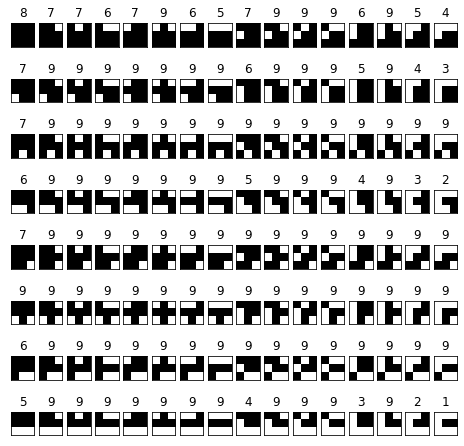

In [13]:
prueba = np.asarray([[0,1,0],[0,0,0],[0,1,0]])

fig, axes = plt.subplots(8, 16, figsize=(8, 8))
ax = axes.ravel()

for i in range(128):
  iBinario = bin(i)[2:]

  prueba = np.zeros((3,3))

  prueba[1,1] = 0

  prueba[0,2] = bitBinarion(i, 0)
  prueba[0,1] = bitBinarion(i, 1)
  prueba[0,0] = bitBinarion(i, 2)
  prueba[1,0] = bitBinarion(i, 3)
  prueba[2,0] = bitBinarion(i, 4)
  prueba[2,1] = bitBinarion(i, 5)
  prueba[2,2] = bitBinarion(i, 6)
  prueba[1,2] = bitBinarion(i, 7)

  ax[i].imshow(prueba, cmap=plt.cm.gray)
  ax[i].get_xaxis().set_visible(False)
  ax[i].get_yaxis().set_visible(False)
  ax[i].set_title(lbpPixel(prueba,1,1))


# LPB para Reconocimiento de Rostros

Aprobechando que LPB es un descriptor de texturas robusto a los cambios de iluminacion, podemos utilizarlo similarmente a HOG para crear descriptores unicos de objetos. En este caso lo usaremos para encontrar patrones especificos en rostros, que luego usaremos para identificarlos dentro de otras fotos.

Para esta parte utilizaremos un subset de FERET, un data set para reconocimiento de rostros. Las imagenes se puede descargar en [github](https://github.com/VILAlab/FERETsubset)

Este procedimiento se basa completamente en [Face Recognition with Local Binary Patterns](https://link.springer.com/chapter/10.1007/978-3-540-24670-1_36)

## Cargamos un rostro

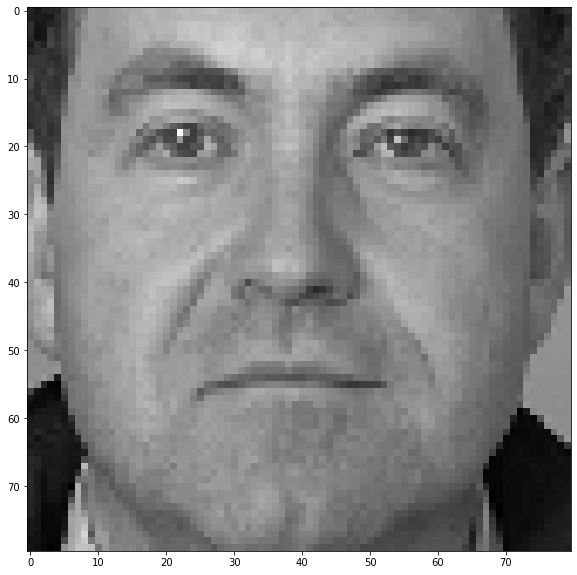

In [3]:
imagenFilename = os.path.join("./subset/cara1", '01.tif')
imagenPrueba = io.imread(imagenFilename, as_gray=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(imagenPrueba, cmap=plt.cm.gray)

## Separamos la cara en 7x7 celdas

Imagen Original: (80, 80)
Imagen ReEscalada: (70, 70)


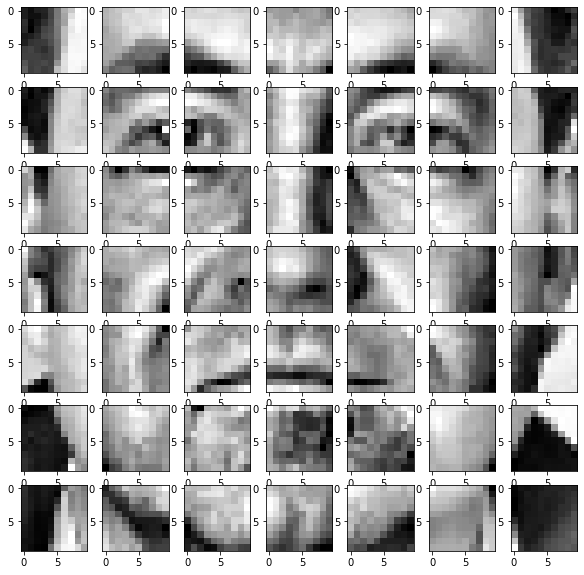

In [4]:
# Ya que las imagenes son de 80x80, debemos cambiar sus dimensiones para poder
# separarlas en 7x7 celdas iguales.
print(f"Imagen Original: {imagenPrueba.shape}")

imagenReEscalada = resize(imagenPrueba, (70, 70))
print(f"Imagen ReEscalada: {imagenReEscalada.shape}")

# Creamos las divisiones de 7x7 celdas. Primero dividimos la imagen en 7 filas
# y luego dividimos cada una en 7 columnas
divisiones = []
divicionesVerticales = np.split(imagenReEscalada, 7, axis=0)
for i in range(7):
  divicionesHorizontales = np.split(divicionesVerticales[i], 7, axis=1)
  divisiones.extend(divicionesHorizontales)

fig, axes = plt.subplots(7, 7, figsize=(10, 10))
ax = axes.ravel()
for i in range(49):
  ax[i].imshow(divisiones[i], cmap=plt.cm.gray)



## Aplicamos LBP en cada celda de la imagen y creamos su histograma

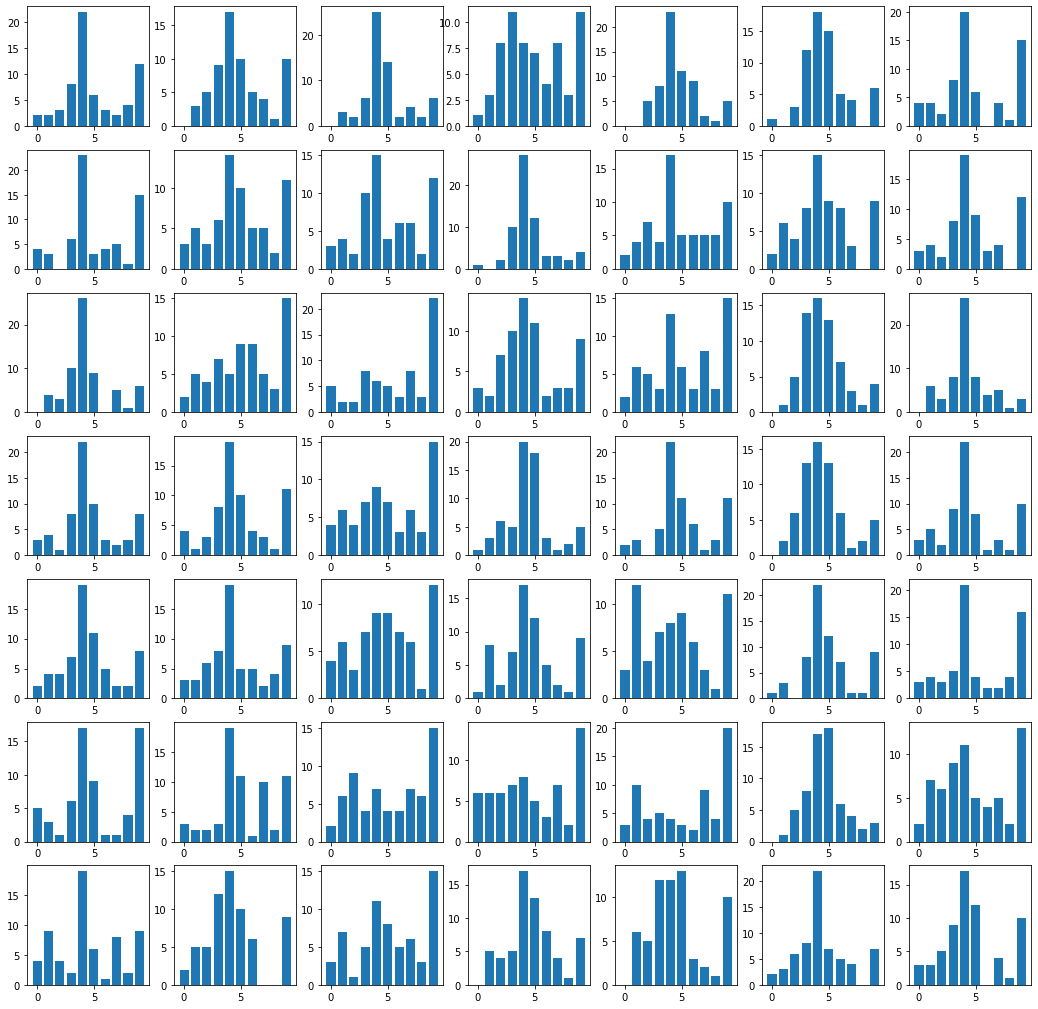

In [14]:
# Creamos una lista donde guardar la imagen LBP y su histograma
divisionesLBP = []
divisionesLBPHistograma = []

# Por cada una de las divisiones, aplicamos LBP en ella y generamos el histograma
# de categorias
for i in range(len(divisiones)):
  imagenLBP = lbpImage(divisiones[i])
  divisionesLBP.append(imagenLBP)
  divisionesLBPHistograma.append(np.histogram(imagenLBP, bins=[0,1,2,3,4,5,6,7,8,9,10])[0])

fig, axes = plt.subplots(7, 7, figsize=(18, 18))
ax = axes.ravel()
for i in range(49):
  ax[i].bar(range(10), divisionesLBPHistograma[i])

## Generamos el Descriptor Unico del Rosto

In [15]:
# Creamos el descriptor unico concatenando cada uno de los histogramas
descriptorUnico = np.concatenate(divisionesLBPHistograma,axis=0)

# **Ejercicio**:
Elegir 3 caras distintas del DataSet **FERET**, para cada una de ellas escogan una foto y calculen el histograma de categorias de LBP. Luego seleccionen otra foto de los rostros elegidos (preferentemente la que tiene un cambio en iluminacion), creen su histograma y calculen la diferencia Chi2 contra los demas histogramas. Verifiquen si el mejor puntaje lo obtuvo el histograma del mismo rostro.

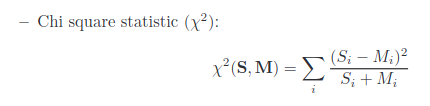

Recuerden que esta comparacion se realiza celda a celda y la suma de cada una sera el puntaje real. Tambien agreguen a la ecuacion un factor de peso segun la celda que estan comparando, de esta forma las celdas donde normalmente se encuentras los ojos deberian valer el doble.

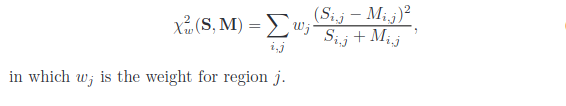

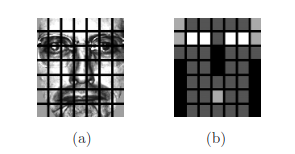

*(Negro significa que esas celdas no tienen peso, blanco significa que valen el doble)*

In [18]:
cara1aFN = os.path.join("./subset/cara1", '01.tif')
cara1a = io.imread(cara1aFN, as_gray=True)

cara2aFN = os.path.join("./subset/cara2", '01.tif')
cara2a = io.imread(cara2aFN, as_gray=True)

cara3aFN = os.path.join("./subset/cara3", '01.tif')
cara3a = io.imread(cara3aFN, as_gray=True)

cara1aRe = resize(cara1a, (70, 70))
cara2aRe = resize(cara2a, (70, 70))
cara3aRe = resize(cara3a, (70, 70))
caras = [cara1aRe, cara2aRe, cara3aRe]
hists = []
pesos = [[1,0.5,0.5,0.5,0.5,0.5,1],
         [1,2,2,0.5,2,2,1],
         [0.5,0.5,0.5,0,0.5,0.5,0.5],
         [0,0.5,0.5,0,0.5,0.5,0],
         [0,0.5,0.5,0.5,0.5,0.5,0],
         [0,0.5,0.5,1,0.5,0.5,0],
         [0,0.5,0.5,0.5,0.5,0.5,0]]

def chidif(hist1, hist2, peso):
  suma = 0
  for i in range(hist1):
    suma += peso*((hist1[i]-hist2[i])**2)/(hist1[i]+hist2[i])
  return suma


for cara in caras:
  divisiones = []
  divicionesVerticales = np.split(cara, 7, axis=0)
  for i in range(7):
    divicionesHorizontales = np.split(divicionesVerticales[i], 7, axis=1)
    divisiones.extend(divicionesHorizontales)

  divisionesLBP = []
  divisionesLBPHistograma = []

  for i in range(len(divisiones)):
    imagenLBP = lbpImage(divisiones[i])
    divisionesLBP.append(imagenLBP)
    divisionesLBPHistograma.append(np.histogram(imagenLBP, bins=[0,1,2,3,4,5,6,7,8,9,10])[0])
  hists.append(divisionesLBPHistograma)

diferencias = []
for i in range(len(hists)):
  difi = []
  for j in range(len(hists)):
    suma = 0
    for k1 in range(len(hists[0])):
      ind = (k1%7,k1//7)
      suma += chidif(hists[i][k1], hists[j][k1], pesos[ind[0],ind[1]])
    difi.append(suma)
  diferencias.append(difi)

difi = np.array(difi)
print(difi)

TypeError: list indices must be integers or slices, not tuple